# Surrender Index

## Functions

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore as perc
import warnings
import boto3
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

s3 = boto3.client('s3')

In [106]:
def scoreDiff(row):
    if row['recTeam'] == row['awayTeam']:
        return row['homeScore'] - row['awayScore']
    else:
        return row['awayScore'] - row['homeScore']
    
def secSinceHalf(row):
    return 1800 - int(row['totTime'])

def fieldPosScore(row):
    if row['dist2goal'] >= 60:
        return 1.0
    elif row['dist2goal'] >= 50:
        return 1.1 ** (40 - row['dist2goal'])
    else:
        return 1.1**10 * 1.2**(50 - row['dist2goal'])

def distScore(row):
    if int(row['distance']) >= 10:
        return 0.2
    elif 7 <= row['distance'] <= 9:
        return 0.4
    elif 4 <= row['distance'] <= 6:
        return 0.6
    elif 2 <= row['distance'] <= 3:
        return 0.8
    else:
        return 1.0
    
def scoreDiffMult(pointdiff):
    if pointdiff > 0:
        return 1
    elif pointdiff == 0:
        return 2
    elif pointdiff < -8:
        return 3
    else:
        return 4

def timeMult(row):
    sec = secSinceHalf(row)
    PD = scoreDiff(row)
       
    if PD <= 0 and sec >= 0:
        return ((sec * 0.001)**3) + 1.
    else:
        return 1.
    
def surrenderIndex(row):
    pd = scoreDiff(row)
    Q = row['Q']
#     if Q > 4:
#         otMult = 2
#     else:
#         otMult = 1
#     print(fieldPosScore(row),distScore(row),scoreDiffMult(pd),timeMult(row))
    return fieldPosScore(row) * distScore(row) * scoreDiffMult(pd) * timeMult(row)

def recTeam(row):
    if row['teamPoss'] == row['homeTeam']:
        return row['awayTeam']
    else:
        return row['homeTeam']

def touchback(row):
    if 'Touchback' in row['play']:
        return "Touchback"
    elif 'No return' in row['play']:
        return "No return"
    else:
        return "Returned"

def puntDist(row):
    if 'BLOCKED' in row.play:
        return 0
    elif 'Touchback' in row.play:
        return row.dist2goal - 20
    else:
        return int(row.play.split('yards. ')[0].split('of ')[-1])

## Punts

In [108]:
S = 26

# for i in range(S,S+1):
#     print(i)
#     s3.download_file('isfl-surrender-bot','PBP/S%iPBP.csv'%i,'PBP/S%iPBP.csv'%i)


import os
allDF = pd.concat([pd.read_csv('../play_by_play/testLZ/%s'%p) for p in next(os.walk('../play_by_play/testLZ/'))[2] if '.csv' in p])
allDF = allDF.reset_index().sort_values('S')
# allDF.to_csv('allPBP.csv')

In [109]:


puntDF = allDF[allDF['play'].str.contains('Punt ')].dropna()

puntDF['recTeam'] = puntDF.apply(lambda row : recTeam(row),axis=1)

puntDF['surrenderIndex'] = puntDF.apply(lambda row : surrenderIndex(row),axis=1)

puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','teamPoss','recTeam','down','distance','side','dist2goal','surrenderIndex','play']]

#puntDF = puntDF.sort_values('surrenderIndex',ascending=False)

NFL = np.load("2009-2019_surrender_indices.npy")
puntDF['NFLpercentiles'] = puntDF.apply(lambda row : perc(NFL,row['surrenderIndex']),axis=1)

ogDDSPF = pd.read_csv('punts.csv')
puntDF['DDSPF16percentiles'] = puntDF.apply(lambda row : perc(ogDDSPF['surrenderIndex'],row['surrenderIndex']),axis=1)

puntDF['percentiles'] = puntDF.apply(lambda row : perc(puntDF['surrenderIndex'],row['surrenderIndex']),axis=1)

puntDF['result'] = puntDF.apply(lambda row : touchback(row),axis = 1)

puntDF['scoreDiff'] = puntDF.apply(lambda row : scoreDiff(row),axis = 1)

puntDF['puntDist'] = puntDF.apply(lambda row : puntDist(row),axis = 1)

puntDF['puntEndLoc'] = puntDF['dist2goal'] - puntDF['puntDist']

puntDF['surrenderRank'] = puntDF.surrenderIndex.rank(method='max',ascending=False)

puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','teamPoss','recTeam','down','distance','side','dist2goal','puntDist','puntEndLoc','surrenderIndex','surrenderRank','percentiles','DDSPF16percentiles','NFLpercentiles','play','result']]

In [110]:
puntDF.sort_values('surrenderRank').head(10)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,teamPoss,recTeam,down,distance,side,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,DDSPF16percentiles,NFLpercentiles,play,result
48892,2,31,4,6:08,SJS,17,24,COL,SJS,COL,4,2,COL,30,26,4,1252.596798,1.0,100.000000,100.000000,100.000000,"Punt by McDairmid (C), M. of 26 yards. No return. First Down!",No return
154719,8,114,4,4:35,AUS,9,23,YKW,AUS,YKW,4,3,YKW,32,12,20,753.503337,2.0,99.991319,99.991128,100.000000,"Punt by QB (R), P. of 32 yards. Touchback.",Touchback
160181,9,25,4,2:49,SJS,24,28,YKW,SJS,YKW,4,2,YKW,35,30,5,682.704673,3.0,99.982637,99.968948,100.000000,"Punt by McDairmid (C), M. of 30 yards. No return. First Down!",No return
170567,9,16,5,4:16,COL,25,25,BAL,COL,BAL,4,16,BAL,31,11,20,517.021999,4.0,99.973956,99.946768,99.996344,"Punt by Banana, S. of 31 yards. Touchback.",Touchback
20341,10,86,5,1:21,NYS,13,13,HON,HON,NYS,0,0,NYS,41,39,2,507.599605,5.0,99.965275,99.946768,99.996344,"Punt by Powers, V. of 39 yards. No return. First Down!",No return
95954,5,60,4,3:54,HON,7,20,NOLA,HON,NOLA,4,7,NOLA,31,11,20,481.317977,6.0,99.956593,99.933460,99.996344,"Punt by Powers, V. of 31 yards. Touchback.",Touchback
98894,5,115,4,11:17,SAR,28,20,COL,COL,SAR,4,5,SAR,31,11,20,480.533038,7.0,99.947912,99.933460,99.996344,"Punt by Banana, S. of 31 yards. Touchback.",Touchback
75657,4,112,4,2:04,PHI,28,31,NYS,PHI,NYS,4,11,NYS,31,11,20,378.383850,8.0,99.939231,99.897973,99.992688,"Punt by PuntBot, Z. of 31 yards. Touchback.",Touchback
97523,5,76,4,2:17,CHI,20,19,SAR,SAR,CHI,4,5,CHI,37,37,0,372.920034,9.0,99.930550,99.893537,99.992688,"Punt by PhastBawls, D. of 37 yards. No return. First Down!",No return
2320,1,36,4,6:44,OCO,28,14,ARI,ARI,OCO,4,7,OCO,31,11,20,369.963248,10.0,99.921868,99.893537,99.992688,"Punt by Jay-Jaymison, J. of 31 yards. Touchback.",Touchback


In [111]:
puntDF.to_csv('punts21.csv')

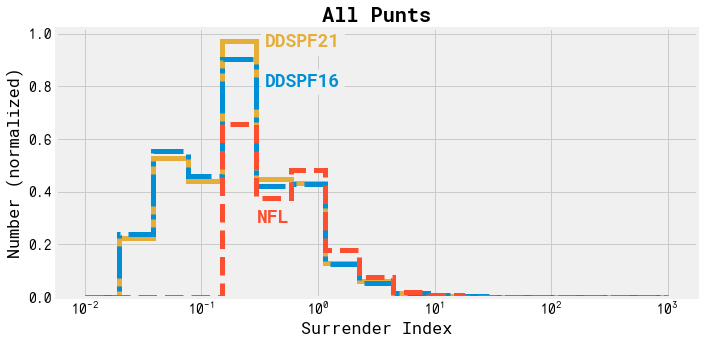

In [112]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'Roboto Mono'
plt.rcParams['font.weight'] = 'medium'
plt.xticks(fontname = 'NovaMono',weight='medium')
plt.yticks(fontname = 'NovaMono',weight='medium')
plt.title('All Punts',weight='bold')
plt.xlabel('Surrender Index')
plt.ylabel('Number (normalized)')
bins = np.logspace(-2,3,18)
plt.hist(puntDF['surrenderIndex'],bins=bins,histtype='step',color='C2',density=True,lw=5,label='DDSPF21')
plt.hist(ogDDSPF['surrenderIndex'],bins=bins,histtype='step',color='C0',ls='-.',density=True,lw=5,label='DDSPF16')
plt.hist(NFL,bins=bins,color='C1',histtype='step',density=True,lw=5,ls='--',label='NFL')
plt.xscale('log')
plt.text(x=0.35,y=0.95,s='DDSPF21',c='C2',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.text(x=0.35,y=0.8,s='DDSPF16',c='C0',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.text(x=0.3,y=0.28,s='NFL',c='C1',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.tight_layout()
plt.savefig('images21/surrenderindexes.png')
plt.show()

In [113]:
puntArr = []
for i in range(30,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntArr.append(i4df['result'].value_counts(normalize=True))

In [114]:
puntArr[3]['Touchback']

0.7419354838709677

In [115]:
tbList = []
nrList = []
rList = []
for f in puntArr:
    try:
        tbList.append(f['Touchback'])
    except KeyError:
        tbList.append(0.)
    try:
        nrList.append(f['No return'])
    except KeyError:
        nrList.append(0.)
    try:
        rList.append(f['Returned'])
    except KeyError:
        rList.append(0.)

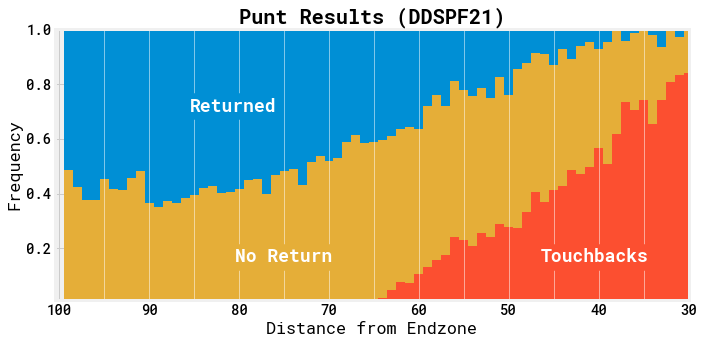

In [282]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results (DDSPF21)',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,rList,bottom=[tbList[i]+nrList[i] for i in range(len(yardRange))],width=1,label='Returned',color='C0',align='center')
plt.bar(yardRange,nrList,bottom=tbList,width=1,label='No Return',color='C2',align='center')
plt.bar(yardRange,tbList,width=1,label='Touchback',color='C1',align='center')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 46.5, y = 0.15, s = 'Touchbacks', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 80.5, y = 0.15, s = 'No Return', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 85.5, y = 0.7, s = 'Returned', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100.5,30.5)
plt.xticks(range(30,110,10))
for i in range(10,100,5):
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images21/punt_results.png')
plt.show()

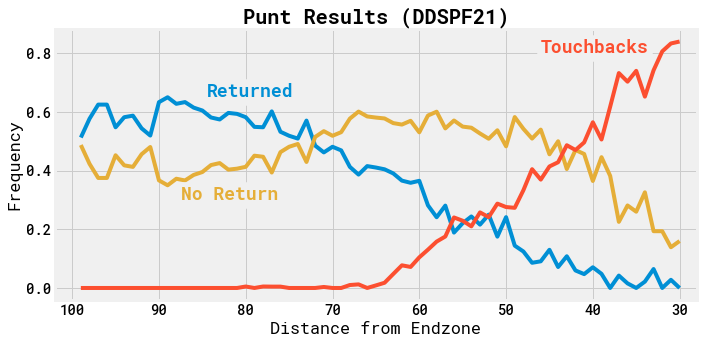

In [231]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results (DDSPF21)',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,rList,label='Returned',color='C0')
plt.plot(yardRange,nrList,label='No Return',color='C2')
plt.plot(yardRange,tbList,label='Touchback',color='C1')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 46, y = 0.8, s = 'Touchbacks', color = 'C1', weight = 'bold', size = 18, rotation = 0, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.3, s = 'No Return', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 84.5, y = 0.65, s = 'Returned', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images21/punt_results_line.png')
plt.show()

In [118]:
puntDF.columns

Index(['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'teamPoss', 'recTeam', 'down', 'distance', 'side',
       'dist2goal', 'puntDist', 'puntEndLoc', 'surrenderIndex',
       'surrenderRank', 'percentiles', 'DDSPF16percentiles', 'NFLpercentiles',
       'play', 'result'],
      dtype='object')

In [119]:
puntDF['surrenderRank'] = puntDF.surrenderIndex.rank(method='max',ascending=False)
puntDF = puntDF[['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'recTeam', 'down', 'distance', 'dist2goal', 'puntDist',
       'puntEndLoc', 'surrenderIndex','surrenderRank', 'percentiles', 'NFLpercentiles', 'play',
       'result']]

array([[<AxesSubplot:title={'center':'puntEndLoc'}>]], dtype=object)

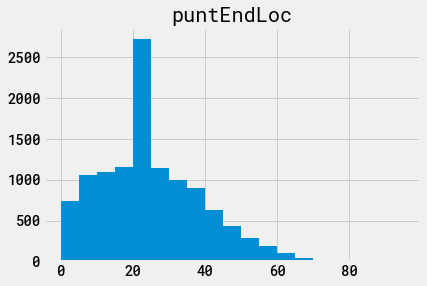

In [120]:
puntDF.hist('puntEndLoc',bins=np.arange(0,100,5))

array([[<AxesSubplot:title={'center':'dist2goal'}>]], dtype=object)

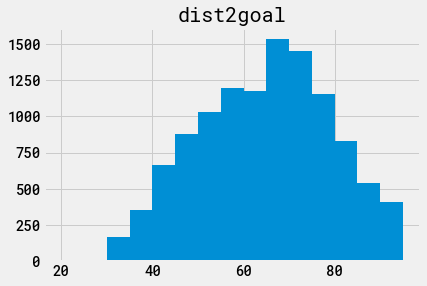

In [121]:
puntDF.hist('dist2goal',bins=np.arange(20,100,5))

In [122]:
min(puntDF.dist2goal)

30

In [123]:
puntEndArr = []
for i in range(0,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntEndArr.append(i4df['puntEndLoc'].value_counts(normalize=True))

In [124]:
in20 = 0
tb = 0
out20 = 0
for key,val in puntEndArr[30].items():
    if key < 20:
        in20 += val
    elif key == 20:
        tb += val
    else:
        out20 += val
print(in20, tb, out20)

0.16 0.84 0


In [125]:
in20List = []
tb20List = []
out20List = []
for f in puntEndArr[30:]:
    in20 = 0
    tb = 0
    out20 = 0
    for key,val in f.items():
        if key < 20:
            in20 += val
        elif key == 20:
            tb += val
        else:
            out20 += val
    in20List.append(in20)
    tb20List.append(tb)
    out20List.append(out20)

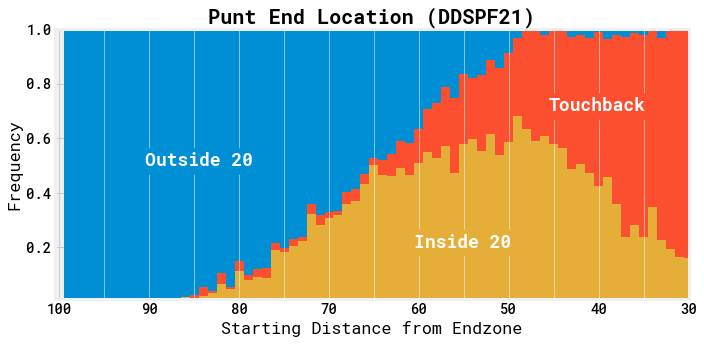

In [283]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt End Location (DDSPF21)',weight='bold')
plt.xlabel('Starting Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,out20List,bottom=[tb20List[i]+in20List[i] for i in range(len(yardRange))],width=1,label='Outside 20',color='C0',align='center')
plt.bar(yardRange,tb20List,bottom=in20List,width=1,label='Touchback',color='C1',align='center')
plt.bar(yardRange,in20List,width=1,label='Inside 20',color='C2',align='center')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 60.5, y = 0.2, s = 'Inside 20', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 45.5, y = 0.7, s = 'Touchback', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 90.5, y = 0.5, s = 'Outside 20', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100.5,30.5)
plt.xticks(range(30,110,10))
for i in range(10,100,5):
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images21/punt_results.png')
plt.show()

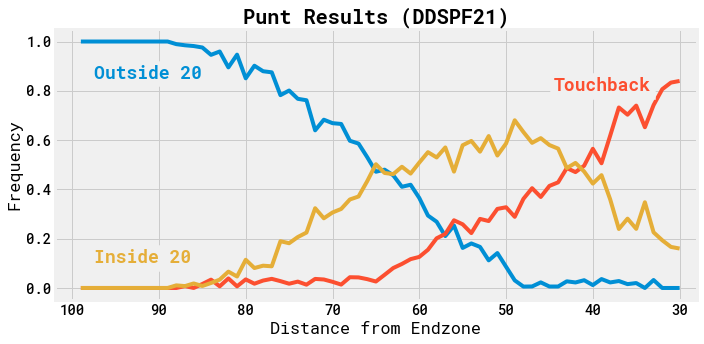

In [242]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results (DDSPF21)',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,out20List,label='Outside 20',color='C0')
plt.plot(yardRange,tb20List,label='Touchback',color='C1')
plt.plot(yardRange,in20List,label='Inside 20',color='C2')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 44.5, y = 0.8, s = 'Touchback', color = 'C1', weight = 'bold', size = 18, rotation = 0, backgroundcolor = '#f0f0f0')
plt.text(x = 97.5, y = 0.1, s = 'Inside 20', color = 'C2', weight = 'bold', size = 18, rotation = 0, backgroundcolor = '#f0f0f0')
plt.text(x = 97.5, y = 0.85, s = 'Outside 20', color = 'C0', weight = 'bold', size = 18, rotation = 0,backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images21/punt_results_line.png')
plt.show()

In [128]:
puntDF[puntDF.puntEndLoc < 20].sort_values('dist2goal',ascending = False).head(10)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,result
3742,1,118,4,8:14,NYS,21,10,SJS,NYS,4,12,88,83,5,1.936536,3605.0,68.712562,63.962416,"Punt by McDairmid (C), M. of 83 yards. No return. First Down!",No return
89542,5,85,3,8:15,BER,13,24,HON,HON,4,19,87,69,18,0.639858,6907.0,40.046879,28.875402,"Punt by Hunt, K. of 69 yards. Returned by Waters, J. for 7 yards. First Down!",Returned
26303,10,56,1,9:24,SJS,0,0,PHI,PHI,4,13,86,68,18,0.400000,9023.0,25.805191,14.392001,"Punt by McDairmid (C), M. of 68 yards. No return. First Down!",No return
66375,3,31,2,11:09,SJS,7,10,COL,COL,4,21,86,68,18,0.800000,6669.0,46.501432,35.927903,"Punt by McDairmid (C), M. of 68 yards. Returned by Purchase, L. for 14 yards. First Down!",Returned
72407,4,25,1,13:36,SJS,0,0,YKW,YKW,4,19,85,66,19,0.400000,9023.0,25.805191,14.392001,"Punt by McDairmid (C), M. of 66 yards. No return. First Down!",No return
15731,1,46,1,4:29,YKW,3,0,SJS,YKW,4,10,84,66,18,0.800000,6669.0,46.501432,35.927903,"Punt by McDairmid (C), M. of 66 yards. No return. First Down!",No return
30909,10,104,3,7:22,BER,14,10,SJS,BER,4,17,84,66,18,0.876858,5473.0,52.495876,41.872624,"Punt by McDairmid (C), M. of 66 yards. No return. First Down!",No return
119534,6,114,3,13:00,AUS,16,13,YKW,AUS,4,10,84,67,17,0.801382,5622.0,51.206702,40.803232,"Punt by Kokot (R), B. of 67 yards. No return. First Down!",No return
17838,10,41,3,7:00,COL,17,19,OCO,OCO,4,3,83,64,19,3.553894,2184.0,81.048702,79.639514,"Punt by Banana, S. of 64 yards. Returned by Beerus, L. for 15 yards. First Down!",Returned
129700,7,51,4,0:45,BAL,44,19,PHI,PHI,4,4,83,64,19,0.600000,7755.0,34.803368,23.115311,"Punt by Small, J. of 64 yards. No return. First Down!",No return


In [129]:
# puntDF.to_csv('allpunts.csv')

## Fourth Downs

In [130]:
allData = allDF.copy()
fourthDF = allData[allData['down'] == 4.0]

In [131]:
def playType(play):
#     print(play)
    if 'Punt' in play:
        ptype = 'Punt'
    elif 'FG' in play:
        ptype = 'FG'
    elif 'Timeout' in play:
        ptype = 'Timeout'
    elif 'kicks off' in play:
        ptype = 'Kickoff'
    else:
        ptype = 'Try'
    return ptype

In [132]:
fourthDF = fourthDF.rename(columns = {'teamPoss':'recTeam'})

In [133]:
fourthDF['playType'] = fourthDF.apply(lambda row : playType(row['play']),axis=1)

In [134]:
def fixAZBug2(row):
    try:
        if row['recTeam'] == 'AZ' and row['playType'] == 'Punt':
            row['dist2goal'] = 100 - row['dist2goal']
            if row['homeTeam'] == 'AZ':
                row['side'] = row['awayTeam']
            else:
                row['side'] = row['homeTeam']
        return row
    except KeyError:
        return row

In [135]:
#fourthDF = fourthDF.apply(lambda row : fixAZBug2(row),axis=1)

In [136]:
fourthDF['scoreDiff'] = fourthDF.apply(lambda row : scoreDiff(row),axis=1)

In [137]:
fourthDF = fourthDF[~fourthDF['playType'].str.contains('Timeout')]

In [138]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Penalty')]
fourthDF = fourthDF[~fourthDF['play'].str.contains('kicks off')]

In [139]:
fourthTryDF = fourthDF[fourthDF['playType'] == 'Try']

In [140]:
# fourthDF = fourthDF[~fourthDF['play'].str.contains('Turnover')]

In [141]:
fourthDF['playType'].value_counts(normalize=True)

Punt    0.646240
FG      0.243939
Try     0.109820
Name: playType, dtype: float64

In [142]:
fourthArr = []
for i in range(1,100):
    i4df = fourthDF[fourthDF['dist2goal'] == i]
    fourthArr.append(i4df['playType'].value_counts(normalize=True))

In [143]:
fourthArr[0]['FG']

0.9640718562874252

In [144]:
FGlist = []
PuntList = []
TryList = []
TOList = []
for f in fourthArr:
    try:
        FGlist.append(f['FG'])
    except KeyError:
        FGlist.append(0.)
    try:
        PuntList.append(f['Punt'])
    except KeyError:
        PuntList.append(0.)
    try:
        TryList.append(f['Try'])
    except KeyError:
        TryList.append(0.)
    try:
        TOList.append(f['Timeout'])
    except KeyError:
        TOList.append(0.)

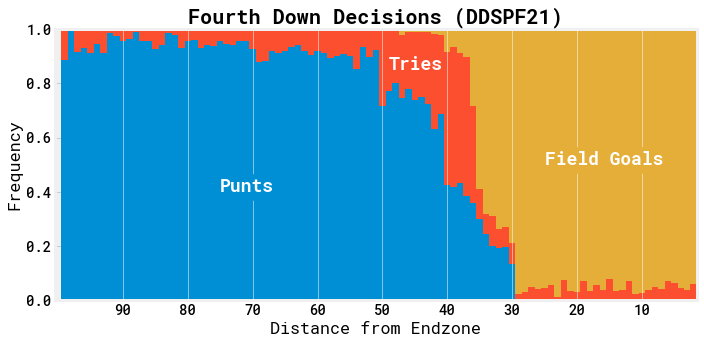

In [275]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions (DDSPF21)',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,FGlist,bottom=[TryList[i]+PuntList[i] for i in range(99)],width=1,label='Field Goals',color='C2',align='center')
plt.bar(yardRange,TryList,bottom=PuntList,width=1,label='Tries',color='C1',align='center')
plt.bar(yardRange,PuntList,width=1,label='Punts',color='C0',align='center')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(100.5,1.5)
plt.xticks(range(10,100,10))
plt.ylim(0,1)
plt.text(x = 49, y = 0.85, s = 'Tries', color = 'w', weight = 'bold', size = 18,)
plt.text(x = 25, y = 0.5, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 75, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
# plt.legend(loc=5)
plt.tight_layout()
plt.savefig('images21/4thdownbar.png')
plt.show()

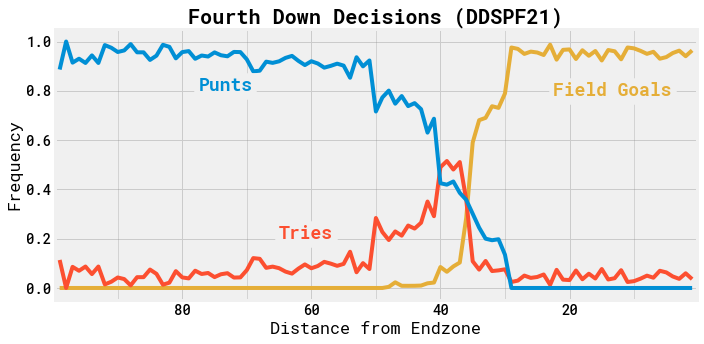

In [251]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions (DDSPF21)',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
for i in [10,30,50,70,90]:
    plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
plt.xlim(99.75,0.25)
# plt.ylim(0,1)
# plt.legend(loc=5)
plt.text(x = 65, y = 0.2, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 22.5, y = 0.78, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 77.5, y = 0.8, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/4thdownline.png')
plt.show()

In [252]:
puntList16 = [0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1774193548387097,
 0.3993808049535604,
 0.44662921348314605,
 0.4692556634304207,
 0.5013927576601671,
 0.45592705167173253,
 0.4375,
 0.5333333333333333,
 0.546875,
 0.5365853658536586,
 0.5669291338582677,
 0.8672566371681416,
 0.829683698296837,
 0.8415584415584415,
 0.8594164456233422,
 0.8708010335917312,
 0.8372093023255814,
 0.8265060240963855,
 0.8489208633093526,
 0.8835164835164835,
 0.8411214953271028,
 0.8986175115207373,
 0.8983050847457628,
 0.8782051282051282,
 0.8819742489270386,
 0.8587196467991169,
 0.8475991649269311,
 0.8532731376975169,
 0.9004237288135594,
 0.8635514018691589,
 0.8641975308641975,
 0.8724954462659381,
 0.8851851851851852,
 0.8757062146892656,
 0.8983666061705989,
 0.8822269807280514,
 0.8807157057654076,
 0.8755458515283843,
 0.9081632653061225,
 0.8846960167714885,
 0.8839907192575406,
 0.9269340974212035,
 0.9126853377265239,
 0.9321486268174475,
 0.9444444444444444,
 0.933572710951526,
 0.917098445595855,
 0.9368029739776952,
 0.9108910891089109,
 0.9288537549407114,
 0.9194847020933977,
 0.9456521739130435,
 0.9329758713136729,
 0.9320113314447592,
 0.9393939393939394,
 0.9294478527607362,
 0.9384057971014492,
 0.9283018867924528,
 0.91324200913242,
 0.9594594594594594,
 0.9583333333333334,
 0.9269662921348315,
 0.9602649006622517,
 0.9318181818181818,
 0.8896551724137931,
 0.8979591836734694,
 0.875,
 0.9491525423728814,
 0.9736842105263158,
 0.9166666666666666]

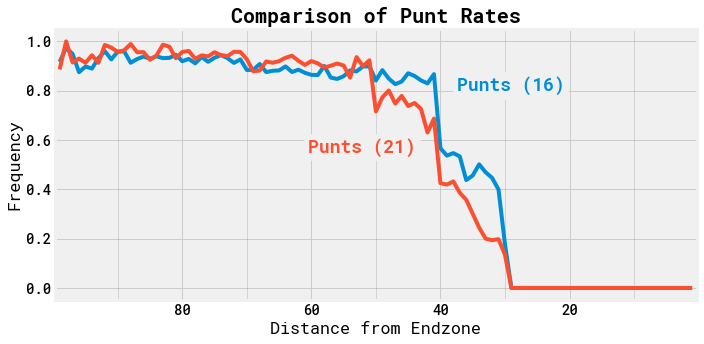

In [258]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Comparison of Punt Rates',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
for i in [10,30,50,70,90]:
    plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.plot(yardRange,puntList16,label='Punts (16)',c='C0')
plt.plot(yardRange,PuntList,label='Punts (21)',c='C1')
plt.xlim(99.75,0.25)
# plt.ylim(0,1)
# plt.legend(loc=5)
plt.text(x = 37.5, y = 0.8, s = 'Punts (16)', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 60.5, y = 0.55, s = 'Punts (21)', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/4thdownline-punts.png')
plt.show()

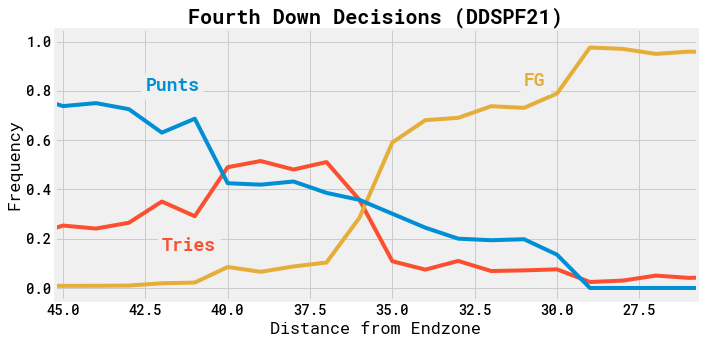

In [263]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions (DDSPF21)',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
# plt.plot(yardRange,TOList,label='Timeouts',c='C3')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
# for i in [10,30,50,70,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.xlim(45.25,25.75)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 42, y = 0.15, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 31, y = 0.82, s = 'FG', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 42.5, y = 0.8, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/4thdown_dead.png')
plt.show()

In [148]:
deadZoneDF = fourthDF[(fourthDF['dist2goal'] <= 40) & (30 <= fourthDF['dist2goal'])]

In [149]:
len(deadZoneDF)

2003

In [150]:
deadZoneArr = []
deadZoneArrn = []
for i in range(1,51):
    i4df = deadZoneDF[deadZoneDF['distance'] == i]
    deadZoneArr.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrn.append(i4df['playType'].value_counts(normalize=False))

In [151]:
dFGlist = []
dPuntList = []
dTryList = []
dTOList = []
noneList = []

for f in deadZoneArr:
    i = 0
    try:
        dFGlist.append(f['FG'])
    except KeyError:
        dFGlist.append(0.)
        i += 1
    try:
        dPuntList.append(f['Punt'])
    except KeyError:
        dPuntList.append(0.)
        i+=1
    try:
        dTryList.append(f['Try'])
    except KeyError:
        dTryList.append(0.)

In [152]:
dFGlistn = []
dPuntListn = []
dTryListn = []
dTOListn = []
noneListn = []

for f in deadZoneArrn:
    i = 0
    try:
        dFGlistn.append(f['FG'])
    except KeyError:
        dFGlistn.append(0.)
        i += 1
    try:
        dPuntListn.append(f['Punt'])
    except KeyError:
        dPuntListn.append(0.)
        i+=1
    try:
        dTryListn.append(f['Try'])
    except KeyError:
        dTryListn.append(0.)

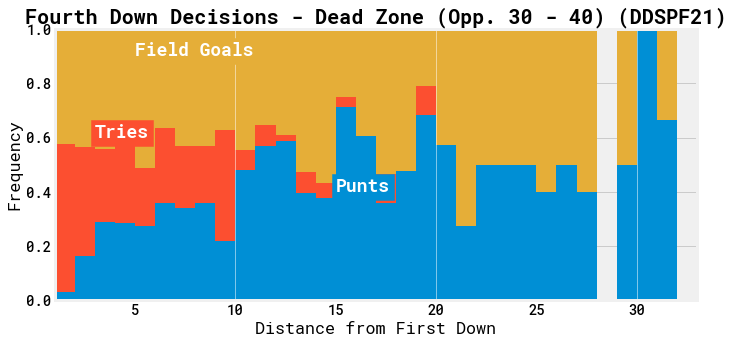

In [153]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40) (DDSPF21)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntList,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryList,bottom=dPuntList,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlist,bottom=[dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 3, y = 0.6, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.9, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 15, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images21/4thdown_deadDist.png')
plt.show()

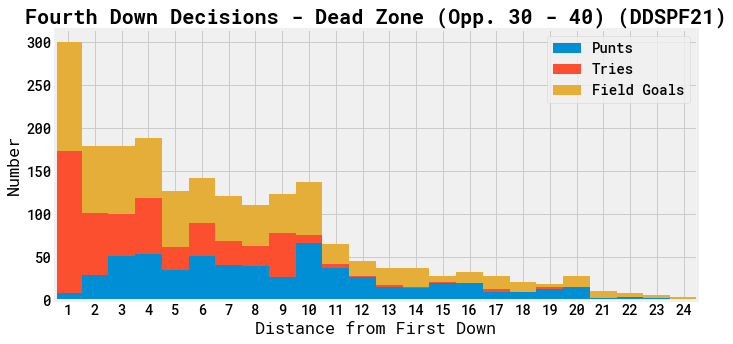

In [271]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40) (DDSPF21)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListn,width=1,label='Punts',align='center')
plt.bar(yardRange,dTryListn,bottom=dPuntListn,width=1,label='Tries',align='center')
plt.bar(yardRange,dFGlistn,bottom=[dTryListn[i]+dPuntListn[i] for i in range(50)],width=1,label='Field Goals',align='center')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0.5,24.5)
plt.xticks(range(1,25))
plt.legend()
plt.tight_layout()
plt.savefig('images21/4thdown_deadDist_total.png')
plt.show()

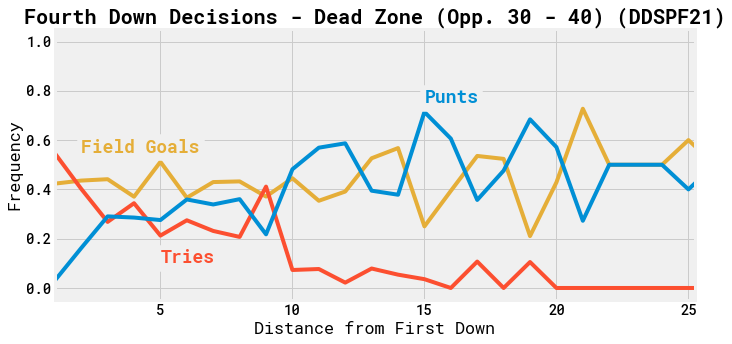

In [266]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40) (DDSPF21)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.plot(yardRange,dFGlist,label='Field Goals',c='C2')
plt.plot(yardRange,dTryList,label='Tries',c='C1')
plt.plot(yardRange,dPuntList,label='Punts',c='C0')
# plt.plot(yardRange,dTOList,label='Timeouts')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,25.25)
# plt.ylim(0,1.01)
# plt.legend(loc=0)
plt.text(x = 5, y = 0.1, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 2, y = 0.55, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 15, y = 0.75, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/4thdown_deadDist_line.png')
plt.show()

In [156]:
deadZoneDF4q = deadZoneDF[deadZoneDF['Q'] >= 4]
len(deadZoneDF4q)

634

In [157]:
deadZoneArrPD = []
deadZoneArrPDn = []
for i in range(0,16):
    i4df = deadZoneDF4q[deadZoneDF4q['scoreDiff'] == i]
    deadZoneArrPD.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrPDn.append(i4df['playType'].value_counts(normalize=False))

In [158]:
dFGlistpd = []
dPuntListpd = []
dTryListpd = []
dTOListpd = []
noneListpd = []

for f in deadZoneArrPD:
    i = 0
    try:
        dFGlistpd.append(f['FG'])
    except KeyError:
        dFGlistpd.append(0.)
        i += 1
    try:
        dPuntListpd.append(f['Punt'])
    except KeyError:
        dPuntListpd.append(0.)
        i+=1
    try:
        dTryListpd.append(f['Try'])
    except KeyError:
        dTryListpd.append(0.)

In [159]:
dFGlistnpd = []
dPuntListnpd = []
dTryListnpd = []
dTOListnpd = []
noneListnpd = []

for f in deadZoneArrPDn:
    i = 0
    try:
        dFGlistnpd.append(f['FG'])
    except KeyError:
        dFGlistnpd.append(0.)
        i += 1
    try:
        dPuntListnpd.append(f['Punt'])
    except KeyError:
        dPuntListnpd.append(0.)
        i+=1
    try:
        dTryListnpd.append(f['Try'])
    except KeyError:
        dTryListnpd.append(0.)

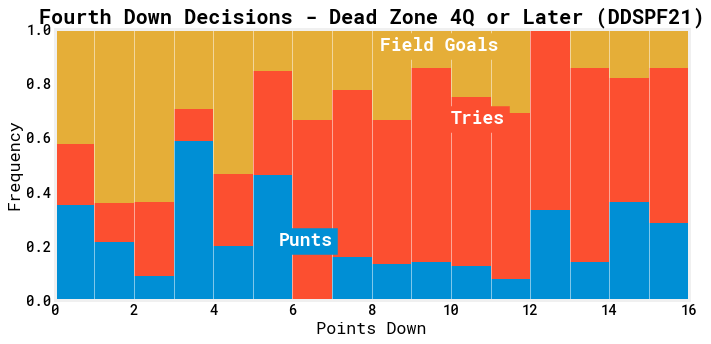

In [160]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone 4Q or Later (DDSPF21)',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntListpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListpd,bottom=dPuntListpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistpd,bottom=[dTryListpd[i]+dPuntListpd[i] for i in range(len(dFGlistpd))],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in range(16):
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 10, y = 0.65, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 8.2, y = 0.92, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 5.65, y = 0.2, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images21/4thdown_deadPD.png')
plt.show()

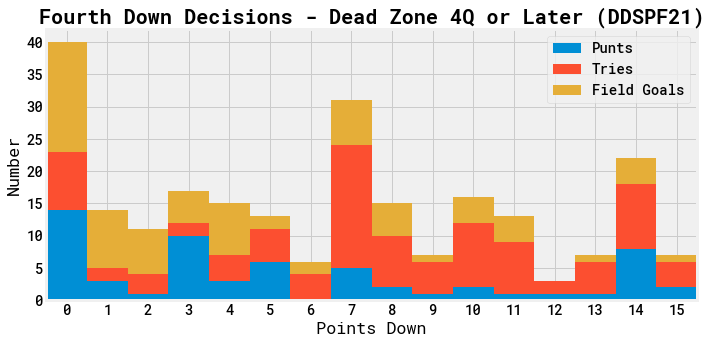

In [270]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone 4Q or Later (DDSPF21)',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListnpd,width=1,label='Punts',align='center')
plt.bar(yardRange,dTryListnpd,bottom=dPuntListnpd,width=1,label='Tries',align='center')
plt.bar(yardRange,dFGlistnpd,bottom=[dTryListnpd[i]+dPuntListnpd[i] for i in range(16)],width=1,label='Field Goals',align='center')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(-0.5,15.5)
plt.xticks(range(0,16))
plt.legend()
plt.tight_layout()
plt.savefig('images21/4thdown_deadPD_total.png')
plt.show()

## Field Goals

In [162]:
FGDF = allData[(allData['play'].str.contains('FG'))]

In [163]:
def fgDist(play):
    return int(play[:2])

In [164]:
FGDF['FGdist'] = FGDF.apply(lambda row : fgDist(row['play']),axis=1)

In [165]:
def fgRes(play):
    if 'BLOCKED' in play:
        return 'Block'
    elif 'NO good' in play:
        return 'Miss'
    else:
        return 'Good'

In [166]:
FGDF['FGresult'] = FGDF.apply(lambda row : fgRes(row['play']),axis=1)

In [167]:
FGDF['FGresult'].value_counts(normalize=True)

Good     0.824584
Miss     0.173040
Block    0.002376
Name: FGresult, dtype: float64

In [287]:
fgDistArr = []
fgDistArrn = []
fgRange = np.arange(20,100,1)
for i in fgRange:
    i4df = FGDF[(i-5 < FGDF['FGdist']) & (FGDF['FGdist'] <= i)]
    fgDistArr.append(i4df['FGresult'].value_counts(normalize=True))
    fgDistArrn.append(i4df['FGresult'].value_counts(normalize=False))

In [288]:
goodList = []
missList = []
blockList = []
for f in fgDistArr:
    try:
        goodList.append(f['Good'])
    except KeyError:
        goodList.append(0.)
    try:
        missList.append(f['Miss'])
    except KeyError:
        missList.append(0.)
    try:
        blockList.append(f['Block'])
    except KeyError:
        blockList.append(0.)

In [289]:
goodListn = []
missListn = []
blockListn = []
for f in fgDistArrn:
    try:
        goodListn.append(f['Good'])
    except KeyError:
        goodListn.append(0.)
    try:
        missListn.append(f['Miss'])
    except KeyError:
        missListn.append(0.)
    try:
        blockListn.append(f['Block'])
    except KeyError:
        blockListn.append(0.)

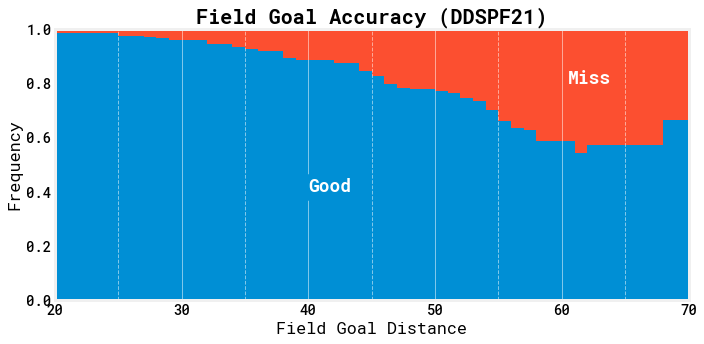

In [290]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy (DDSPF21)',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Frequency')
plt.bar(fgRange,blockList,bottom=[goodList[i]+missList[i] for i in range(len(goodList))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missList,bottom=goodList,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodList,width=5,label='Good',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(20,70)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 60.5, y = 0.8, s = 'Miss', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.4, s = 'Good', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images21/fgResults.png')
plt.show()

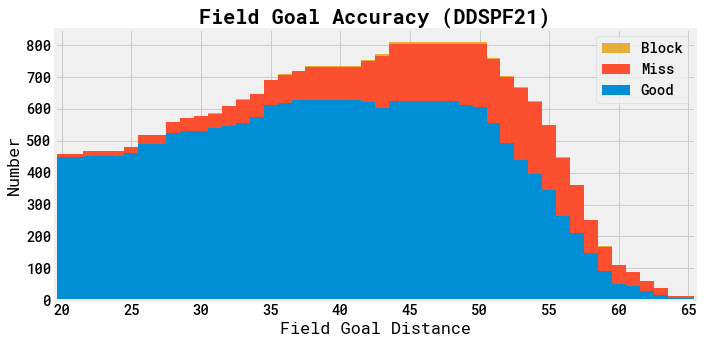

In [296]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy (DDSPF21)',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Number')
plt.bar(fgRange,blockListn,bottom=[goodListn[i]+missListn[i] for i in range(len(goodListn))],width=5,label='Block',color='C2',align='center')
plt.bar(fgRange,missListn,bottom=goodListn,width=5,label='Miss',color='C1',align='center')
plt.bar(fgRange,goodListn,width=5,label='Good',color='C0',align='center')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
plt.xlim(19.5,65.5)
plt.xticks(range(20,70,5))
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images21/fgResults_total.png')
plt.show()

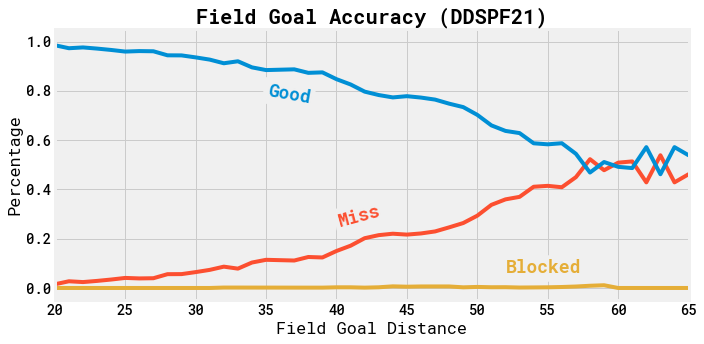

In [297]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy (DDSPF21)',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Percentage')
plt.plot(fgRange,blockList,label='Block',c='C2')
plt.plot(fgRange,missList,label='Miss',c='C1')
plt.plot(fgRange,goodList,label='Good',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(20,65)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.25, s = 'Miss', color = 'C1', weight = 'bold', size = 18, rotation = 15, backgroundcolor = '#f0f0f0')
plt.text(x = 52, y = 0.06, s = 'Blocked', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 35, y = 0.75, s = 'Good', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/fgResults_line.png')
plt.show()

In [298]:
over50 = FGDF[FGDF.FGdist >= 50][['S','gameID','homeTeam','awayTeam','Q','time','down','distance','dist2goal','teamPoss','play','awayScore','homeScore','FGdist','FGresult']].sort_values('FGdist',ascending=False)

(array([119., 134., 108.,  62.,  25.,  33.,  24.,  25.,   4.,   4.,   2.,
          2.,   2.,   3.,   5.,   1.]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <BarContainer object of 16 artists>)

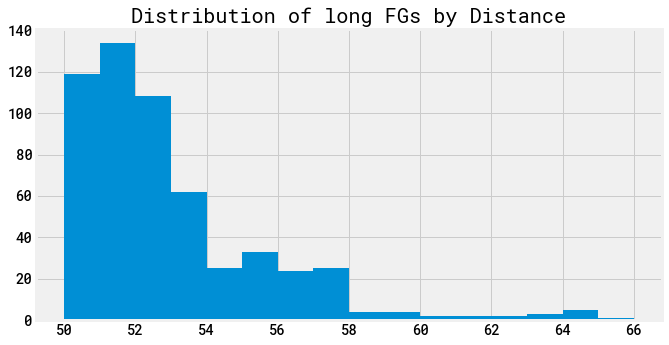

In [299]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5),facecolor='w')
plt.title('Distribution of long FGs by Distance')
plt.hist(over50['FGdist'],bins=np.arange(50,67,1))

In [300]:
FGDF[FGDF['FGresult'] == 'Block']

,index,Unnamed: 0,gameID,S,teamID,Q,time,totTime,down,distance,side,yard,play,awayTeam,homeTeam,teamPoss,dist2goal,awayScore,homeScore,FGdist,FGresult
40776,5601,82,33,2,4,2,0:25,1825,4,4,BAL,27,"44 yard FG by Jay-Jaymison, J. is BLOCKED by BackerBot44, Z..",BAL,ARI,ARI,27,10,14,44,Block
65335,12503,95,16,3,1,3,3:53,1133,4,3,COL,20,"37 yard FG by Small, J. is BLOCKED by Z, D..",COL,BAL,BAL,20,24,24,37,Block
77183,6787,126,61,4,8,4,11:28,688,4,3,BER,26,"43 yard FG by Louis, L. is BLOCKED by Richards (R), E..",BER,NOLA,NOLA,26,20,15,43,Block
93472,5592,7,55,5,5,1,11:41,3401,4,9,PHI,27,"44 yard FG by Dasistwirklichseinnachname, A. is BLOCKED by Howyanow, W..",OCO,PHI,OCO,27,0,0,44,Block
96002,8122,34,90,5,13,1,1:25,2785,4,4,SAR,15,"32 yard FG by Hunt, K. is BLOCKED by Jackson (R), D..",SAR,BER,BER,15,7,2,32,Block
138255,15341,134,81,7,12,4,4:02,242,4,2,NOLA,38,"55 yard FG by Powers, V. is BLOCKED by Blaylock, M..",NOLA,HON,HON,38,28,18,55,Block
129182,6268,87,74,7,10,3,9:29,1469,4,2,NYS,29,"46 yard FG by QB (R), P. is BLOCKED by Griddle, M..",NYS,AUS,AUS,29,7,15,46,Block
147463,6995,66,80,8,11,2,3:26,2006,4,2,NYS,31,"48 yard FG by PhastBawls, D. is BLOCKED by Winchester (R), H..",NYS,SAR,SAR,31,0,12,48,Block
157812,17344,90,82,8,9,3,9:53,1493,4,8,HON,27,"44 yard FG by Sidekick, S. is BLOCKED by Edd, B..",CHI,HON,CHI,27,17,17,44,Block
164572,6528,157,30,9,3,4,0:21,21,3,1,OCO,33,"50 yard FG by Banana, S. is BLOCKED by Biggums, T..",OCO,COL,COL,33,31,28,50,Block


In [301]:
FGDF.sort_values('dist2goal',ascending=False).head(10)

,index,Unnamed: 0,gameID,S,teamID,Q,time,totTime,down,distance,side,yard,play,awayTeam,homeTeam,teamPoss,dist2goal,awayScore,homeScore,FGdist,FGresult
160063,2019,20,25,9,6,1,5:41,3041,4,6,YKW,48,"65 yard FG by McDairmid (C), M. is NO good.",SJS,YKW,SJS,48,0,7,65,Miss
166759,8715,155,56,9,6,4,4:11,251,4,8,PHI,47,"64 yard FG by McDairmid (C), M. is good.",SJS,PHI,SJS,47,37,6,64,Good
45574,10399,59,43,2,6,2,3:37,2017,4,13,OCO,47,"64 yard FG by McDairmid (C), M. is NO good.",SJS,OCO,SJS,47,3,10,64,Miss
166734,8690,130,56,9,6,4,12:22,742,4,15,PHI,47,"64 yard FG by McDairmid (C), M. is good.",SJS,PHI,SJS,47,29,6,64,Good
89925,2045,8,25,5,6,1,11:35,3395,4,11,YKW,47,"64 yard FG by McDairmid (C), M. is good.",SJS,YKW,SJS,47,3,0,64,Good
165408,7364,45,124,9,6,2,11:26,2486,4,1,HON,47,"64 yard FG by McDairmid (C), M. is good.",SJS,HON,SJS,47,10,3,64,Good
62376,9544,163,52,3,2,4,0:23,23,2,10,PHI,46,"63 yard FG by Kokot (R), B. is NO good.",YKW,PHI,YKW,46,31,34,63,Miss
60489,7657,6,37,3,6,1,13:29,3509,4,10,ARI,46,"63 yard FG by McDairmid (C), M. is good.",SJS,ARI,SJS,46,3,0,63,Good
162373,4329,135,34,9,2,4,6:58,418,4,3,ARI,46,"63 yard FG by Kokot (R), B. is NO good.",YKW,ARI,YKW,46,27,24,63,Miss
109078,3756,125,118,6,6,4,13:03,783,4,2,NYS,45,"62 yard FG by McDairmid (C), M. is NO good.",NYS,SJS,SJS,45,10,10,62,Miss


## Drive Endings

In [302]:
todDF = allData[(allData['play'].str.contains('Turnover'))]

In [303]:
tdDF = allData[(allData['play'].str.contains('TOUCHDOWN'))]

In [304]:
safetyDF = allData[(allData['play'].str.contains('SAFETY'))]

In [305]:
intDF = allData[(allData['play'].str.contains('INTERCEPTION'))]

In [306]:
fumbleDF = allData[(allData['play'].str.contains('FUMBLE'))]

In [307]:
pies = [len(puntDF),len(FGDF),len(todDF),len(tdDF),len(intDF),len(fumbleDF),len(safetyDF)]

In [308]:
labels = ['Punts (%.2f%%)'%(len(puntDF)/sum(pies)*100),
          'FG Att (%.2f%%)'%(len(FGDF)/sum(pies)*100),
          'Turnover (%.2f%%)'%(len(todDF)/sum(pies)*100),
          'Touchdown (%.2f%%)'%(len(tdDF)/sum(pies)*100),
          'Interception (%.2f%%)'%(len(intDF)/sum(pies)*100),
          'Fumble (%.2f%%)'%(len(fumbleDF)/sum(pies)*100),
          'Safety (%.2f%%)'%(len(safetyDF)/sum(pies)*100)]

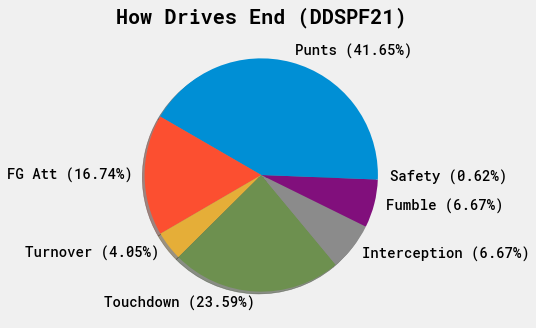

In [309]:
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.title('How Drives End (DDSPF21)',weight='bold')
plt.pie(pies,labels=labels,shadow=True)
plt.savefig('images21/piechart.png')
plt.show()

## Tries

In [186]:
triesDF = fourthTryDF[(fourthTryDF['playType'] == 'Try')]

In [187]:
#triesDF.loc[11659]

In [188]:
turnoverList = triesDF.index[triesDF['play'].str.contains('Turnover')].tolist()

In [189]:
intlist = triesDF.index[triesDF['play'].str.contains('INTERCEPTION')].tolist()

In [190]:
fumblelist = triesDF.index[triesDF['play'].str.contains('FUMBLE')].tolist()

In [191]:
safetylist = triesDF.index[triesDF['play'].str.contains('SAFETY')].tolist()

In [192]:
# turnoverList = [t-1 for t in turnoverList]
turnoverList = turnoverList + intlist + fumblelist + safetylist

In [193]:
triesDF['tryResult'] = 'Good'

In [194]:
triesDF['tryResult'].loc[turnoverList] = 'Fail'

In [195]:
# triesDF = triesDF[~triesDF['play'].str.contains('Turnover')]

In [196]:
triesDF['tryResult'].value_counts(normalize=True)

Fail    0.597343
Good    0.402657
Name: tryResult, dtype: float64

In [197]:
triesDistArr = []
triesDistArrn = []
triesRange = np.arange(1,40,1)
for i in triesRange:
    i4df = triesDF[triesDF['distance'] == i]
    triesDistArr.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn.append(i4df['tryResult'].value_counts(normalize=False))

In [198]:
triesgoodList = []
triesmissList = []
for f in triesDistArr:
    try:
        triesgoodList.append(f['Good'])
    except KeyError:
        triesgoodList.append(0.)
    try:
        triesmissList.append(f['Fail'])
    except KeyError:
        triesmissList.append(0.)

In [199]:
triesgoodListn = []
triesmissListn = []
for f in triesDistArrn:
    try:
        triesgoodListn.append(f['Good'])
    except KeyError:
        triesgoodListn.append(0.)
    try:
        triesmissListn.append(f['Fail'])
    except KeyError:
        triesmissListn.append(0.)

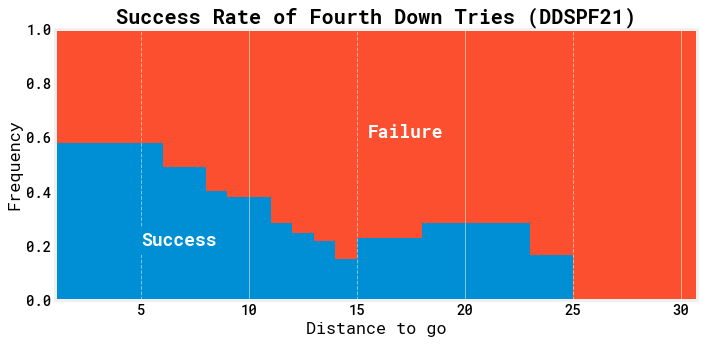

In [200]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries (DDSPF21)',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.bar(triesRange,triesmissList,bottom=triesgoodList,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodList,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,30.75)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 15.5, y = 0.6, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images21/tryResults.png')
plt.show()

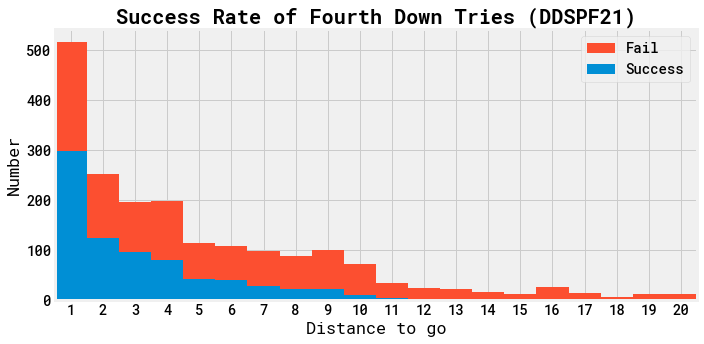

In [312]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries (DDSPF21)',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Number')
plt.bar(triesRange,triesmissListn,bottom=triesgoodListn,width=1,label='Fail',color='C1',align='center')
plt.bar(triesRange,triesgoodListn,width=1,label='Success',color='C0',align='center')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,20.5)
plt.xticks(range(1,21))
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images21/tryResults_total.png')
plt.show()

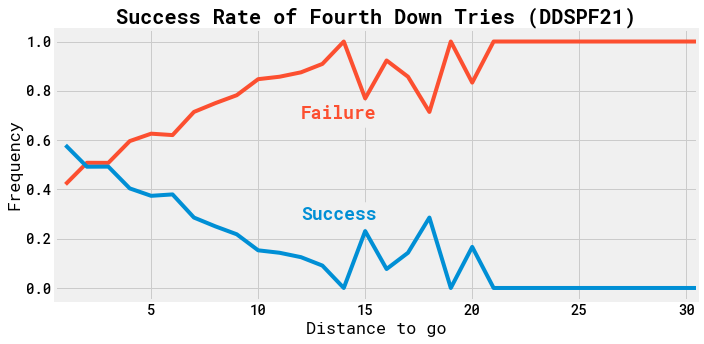

In [315]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries (DDSPF21)',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.plot(triesRange,triesmissList,label='Fail',color='C1')
plt.plot(triesRange,triesgoodList,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 12., y = 0.685, s = 'Failure', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 12., y = 0.275, s = 'Success', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/tryResults_line.png')
plt.show()

In [203]:
triesDistArr2 = []
triesDistArrn2 = []
triesRange2 = np.arange(0,100,5)
for i in triesRange2:
    i4df = triesDF[triesDF['dist2goal'] == i]
    triesDistArr2.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn2.append(i4df['tryResult'].value_counts(normalize=False))

In [204]:
triesgoodList2 = []
triesmissList2 = []
for f in triesDistArr2:
    try:
        triesgoodList2.append(f['Good'])
    except KeyError:
        triesgoodList2.append(0.)
    try:
        triesmissList2.append(f['Fail'])
    except KeyError:
        triesmissList2.append(0.)

In [205]:
triesgoodListn2 = []
triesmissListn2 = []
for f in triesDistArrn2:
    try:
        triesgoodListn2.append(f['Good'])
    except KeyError:
        triesgoodListn2.append(0.)
    try:
        triesmissListn2.append(f['Fail'])
    except KeyError:
        triesmissListn2.append(0.)

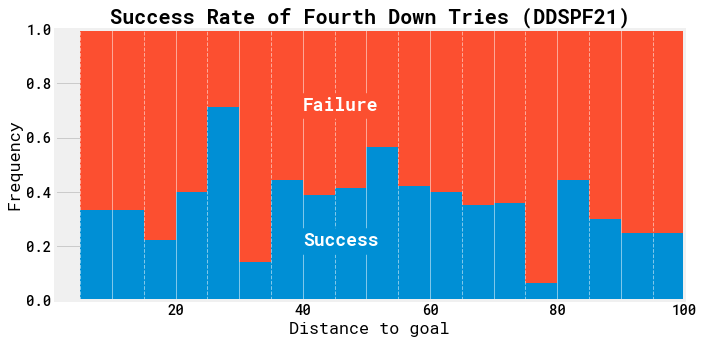

In [206]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries (DDSPF21)',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.bar(triesRange2,triesmissList2,bottom=triesgoodList2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodList2,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65,75,85,95]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,100)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.7, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images21/tryResults_field.png')
plt.show()

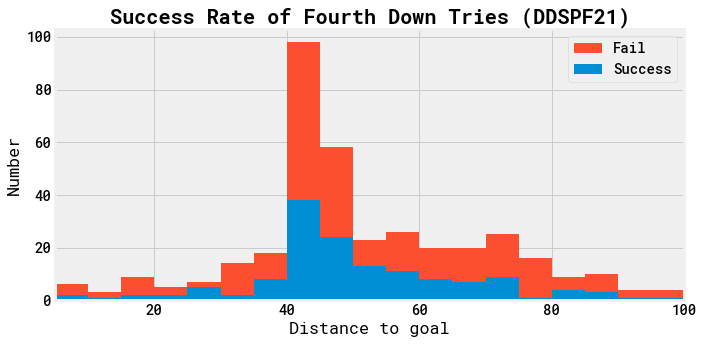

In [207]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries (DDSPF21)',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Number')
plt.bar(triesRange2,triesmissListn2,bottom=triesgoodListn2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodListn2,width=5,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(5,100)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images21/tryResults_field_total.png')
plt.show()

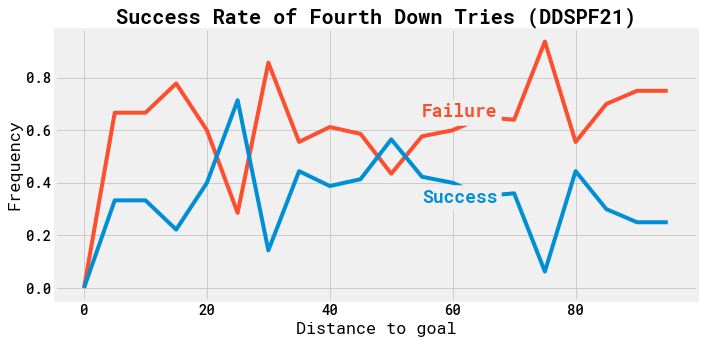

In [208]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries (DDSPF21)',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.plot(triesRange2,triesmissList2,label='Fail',color='C1')
plt.plot(triesRange2,triesgoodList2,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
# plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 55, y = 0.65, s = 'Failure', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 55, y = 0.325, s = 'Success', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images21/tryResults_field_line.png')
plt.show()

In [209]:
pd.set_option('display.max_colwidth', -1)
triesDF[(triesDF['distance']>=15) & (triesDF['tryResult'] == 'Good')].sort_values('distance',ascending=False)

,index,Unnamed: 0,gameID,S,teamID,Q,time,totTime,down,distance,side,yard,play,awayTeam,homeTeam,recTeam,dist2goal,awayScore,homeScore,playType,scoreDiff,tryResult
6876,6876,155,61,1,13,4,2:26,146,4,20,NOLA,29,Rush by Danny King (R) for 29 yds. TOUCHDOWN! (Hunt kick good),BER,NOLA,BER,29,26,36,Try,10,Good
174499,16455,153,105,9,14,4,0:10,10,4,20,NYS,5,"Pass by Howitzer (R) (C), S., complete to Fank (R), H. for 20 yds. Tackle by Cross, M.. First Down!",NYS,PHI,NYS,95,28,32,Try,4,Good
109409,4087,140,117,6,5,4,0:10,10,4,18,OCO,1,"Pass by Ramza (R), S., complete to Trunks, F. for 29 yds. Tackle by Richards (R), E.. First Down!",BER,OCO,OCO,99,41,27,Try,14,Good
25182,7599,148,124,10,6,4,0:09,9,4,18,SJS,30,"Pass by Jack, M., complete to Thomas-Fox, D. for 69 yds. TOUCHDOWN! (McDairmid (C) kick good)",SJS,HON,SJS,70,16,24,Try,8,Good
67061,14229,141,114,3,2,4,6:18,378,4,17,YKW,15,"Pass by Jack, C., complete to Kross, C. for 21 yds. Tackle by Porter, G.. First Down!",AUS,YKW,YKW,85,41,7,Try,34,Good
109103,3781,150,118,6,6,4,3:09,189,4,17,SJS,13,"Pass by Jack, M., complete to Hood, T. for 27 yds. Tackle by Andrews, J.. First Down!",NYS,SJS,SJS,87,20,10,Try,10,Good
15695,15695,144,35,1,4,4,2:20,140,4,16,COL,47,"Pass by Cue (C), J., complete to Passmann, T. for 21 yds. Tackle by Drake (R), J.. First Down!",COL,ARI,ARI,47,44,27,Try,17,Good
103773,15893,170,83,5,12,5,2:57,-723,4,16,HON,34,"Pass by Skywalker (C), L., complete to Alexander, W. for 20 yds. Tackle by MacGregor, G.. First Down!",AUS,HON,HON,66,27,24,Try,3,Good
10160,10160,144,116,1,12,4,2:33,153,4,15,HON,20,"Pass by Skywalker (C), L., complete to Kane-Maika'i, K. for 6 yds. Tackle by Backerbot9, Z.. Automatic First Down!",HON,ARI,HON,80,10,17,Try,7,Good
30506,12923,154,57,10,9,4,0:15,15,4,15,NOLA,39,"Pass by O'Donnell, G., complete to Gelbman, T. for 25 yds. Tackle by Witten, A.. First Down!",CHI,NOLA,CHI,39,7,36,Try,29,Good
